In [21]:
import os
import re
import cv2
import random
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.nn.functional import normalize

The folder contains 9201 images.


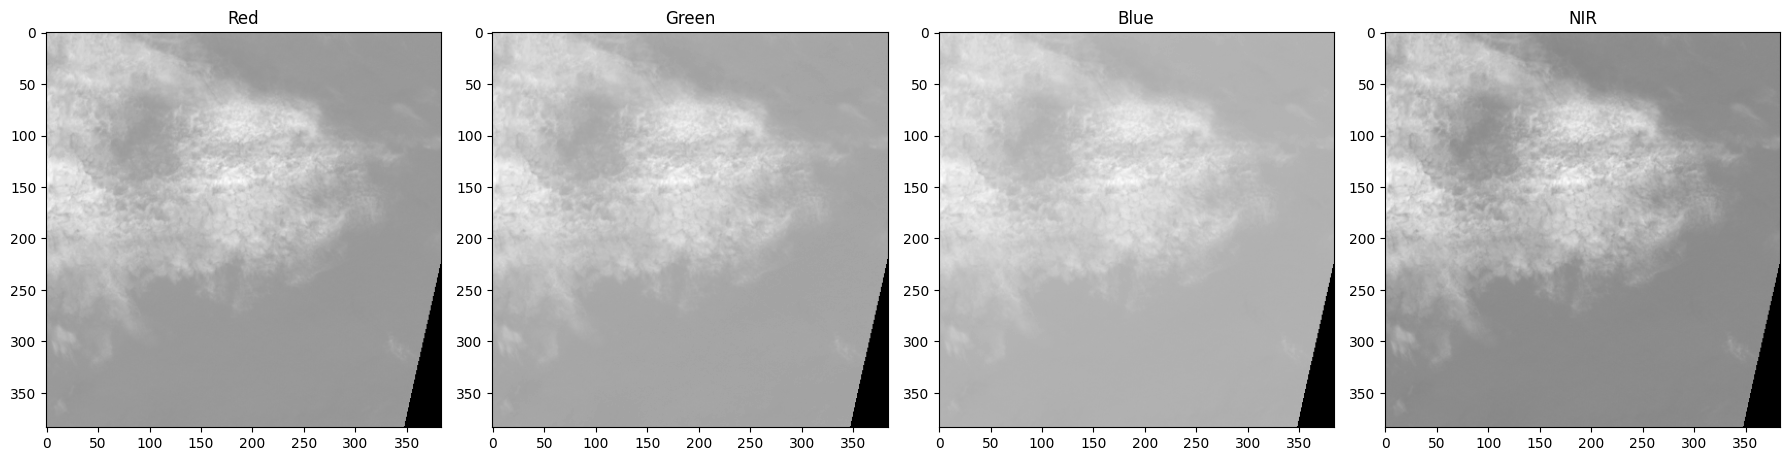

[(3032, 0), (144424, 255)]


In [22]:
ROOT_DIR = r"C:/Users/hdmqu/Downloads/38-Cloud_test/"

RED_PATH = os.path.join(ROOT_DIR, "test_red")
SAVE_DIR = os.path.join(ROOT_DIR, "preds_folder_root/preds_folder")

lst = os.listdir(RED_PATH)
red_images = [RED_PATH + i for i in lst]

print(f"The folder contains {len(red_images)} images.")

image_path = random.choice(red_images)

red_image   = Image.open(image_path)
green_image = Image.open(image_path.replace("red", "green"))
blue_image  = Image.open(image_path.replace("red", "blue"))
nir_image   = Image.open(image_path.replace("red", "nir"))

fig, axs = plt.subplots(1, 4, figsize=(18, 18))
axs[0].imshow(red_image,   cmap="gray")
axs[0].set_title("Red")
axs[1].imshow(green_image, cmap="gray")
axs[1].set_title("Green")
axs[2].imshow(blue_image,  cmap="gray")
axs[2].set_title("Blue")
axs[3].imshow(nir_image,   cmap="gray")
axs[3].set_title("NIR")

fig.tight_layout()
plt.show()

color_list = Image.Image.getcolors(red_image.convert('L'))
print(color_list)

In [23]:
print("No. original images: ", len(red_images))

No. original images:  9201


In [53]:
class CloudTestDataset(Dataset):
    def __init__(self, file_list):
        super().__init__()
        self.files = [self.combine_files(f)
                      for f in file_list if not os.path.isdir(f)]


    def combine_files(self, r_file):
        files = {
            "red":   r_file,
            "green": r_file.replace("red", "green"),
            "blue":  r_file.replace("red", "blue"),
            "nir":   r_file.replace("red", "nir")
        }
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, include_nir=False):
        # Image
        raw_rgb = np.stack([
            cv2.imread(self.files[idx]["red"])[:, :, 0],
            cv2.imread(self.files[idx]["green"])[:, :, 0],
            cv2.imread(self.files[idx]["blue"])[:, :, 0],
        ], axis=2).transpose((2, 0, 1))

        if include_nir:
            nir = np.expand_dims(cv2.imread(self.files[idx]["nir"]), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
            
        # Normalize
        image = torch.tensor(raw_rgb / np.iinfo(raw_rgb.dtype).max)
        
        # Scene IDs
        id = os.path.basename(self.files[idx]["red"] \
                .replace("red_", "")) \
                .replace(".TIF", "")

        return image, id

    def __repr__(self):
        return f"Dataset class with {self.__len__()} files"


test_dataset = CloudTestDataset(red_images)

print(test_dataset)

Dataset class with 9201 files


In [25]:
class C_FCN(nn.Module):
    def __init__(self, in_channels, out_channels, proto: str, skip_connections=False):
        super().__init__()

        self.skip_connections = skip_connections

        self.conv1 = self.contract_block(in_channels, 5)
        self.conv2 = self.contract_block(5, 2)

        if proto == "BI":
            self.out = self.output_block(2, out_channels)
            self.final = nn.UpsamplingBilinear2d(scale_factor=4)

        elif proto == "TC":
            self.out = self.output_block(2, 2)
            self.final = nn.ConvTranspose2d(
                2, out_channels, stride=4, kernel_size=4, padding=0)

        elif proto == "DT":
            self.out = self.output_block(2, 2)
            self.final = nn.Sequential(
                nn.ConvTranspose2d(2, 2, stride=4, kernel_size=4, padding=0),
                nn.ConvTranspose2d(2, out_channels, stride=4, kernel_size=4, padding=0))

        else:
            raise ValueError()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        out = self.out(out)
        out = self.final(out)

        # Skipped connections
        if self.skip_connections:
            self.skip_con = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(4, 1, kernel_size=3, padding=1)
            )
            out = self.skip_con(torch.cat((out, x), dim=1))

        return out

    def contract_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        return contract

    def output_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        out = nn.Sequential(
            nn.Conv2d(in_channels, 2, kernel_size=kernel_size,
                      padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(2, out_channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
        return out


In [26]:
# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")

Using cpu device.


In [57]:
def model_test(model):
    model.eval()
    model.double()
    
    for image, id in tqdm(test_dataset):
        image.to(DEVICE)
        pred = model(image.unsqueeze(0))
        
        pth = os.path.join(SAVE_DIR, id + ".pt")
        
        torch.save(normalize(pred.squeeze()), pth)

In [58]:
pth = r"C:\Users\hdmqu\Documents\GitHub\Improved_C-FCN\models\C-FCN_BI_T_150_iter_1.pth"

sd = torch.load(pth, map_location=DEVICE)
sd.pop("final.1.weight")
sd.pop("final.1.bias")

model = C_FCN(3, 1, "BI", False)
model.load_state_dict(sd)
model_test(model)

100%|██████████| 9201/9201 [09:56<00:00, 15.42it/s]
